Época 0, Loss: 1.3248
Época 10, Loss: 0.8920
Época 20, Loss: 0.5857
Época 30, Loss: 0.4930
Época 40, Loss: 0.4731
Época 50, Loss: 0.4575
Época 60, Loss: 0.4431
Época 70, Loss: 0.4293
Época 80, Loss: 0.4124
Época 90, Loss: 0.4145


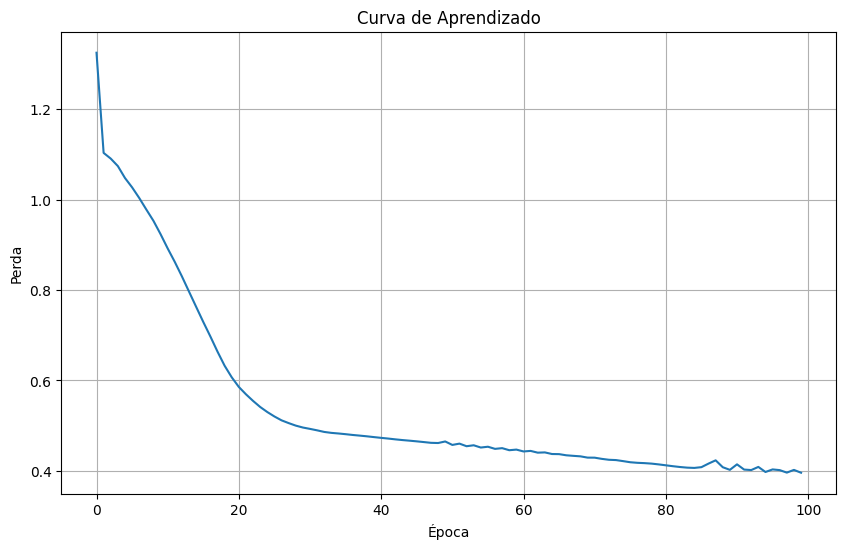

Acurácia no conjunto de teste: 80.00%


C:\Users\mateu\AppData\Local\Temp\ipykernel_26528\2369820271.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
C:\Users\mateu\AppData\Local\Temp\ipykernel_26528\2369820271.py:172: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.arange(y_min, y_max, 0.1))


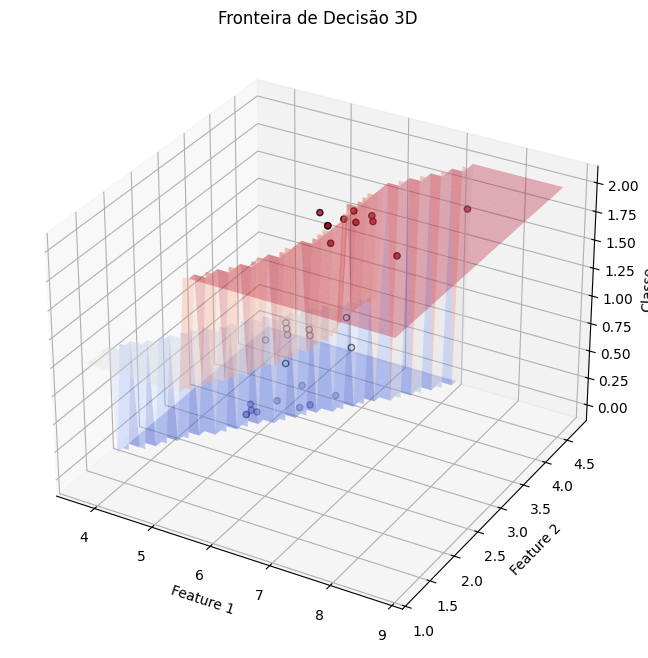

Previsão para [5.0, 3.5]: Classe 0


In [2]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import random
from mpl_toolkits.mplot3d import Axes3D

# Definindo a seed para reprodutibilidade
def set_seed(seed: int = 100):
    """Define uma seed para reprodutibilidade."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

set_seed(42)

# Carregando o conjunto de dados Iris
def create_dataset() -> tuple:
    """Carrega o conjunto de dados Iris para classificação.
    
    Returns:
        Tupla contendo features e labels
    """
    iris = load_iris()
    X = iris.data[:, :2]  # Usando apenas as duas primeiras features para visualização 2D
    y = iris.target
    return X, y

X, y = create_dataset()

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convertendo para tensores PyTorch
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Definindo a rede neural
class SimpleNeuralNetwork(nn.Module):
    """Uma rede neural simples para classificação binária."""
    
    def __init__(self, input_size: int = 2):
        """Inicializa a arquitetura da rede.
        
        Args:
            input_size: Dimensão da camada de entrada
        """
        super().__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 3)  # Alterado para 3 classes
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Define o passo forward da rede."""
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Instanciando o modelo
model = SimpleNeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Função para treinar o modelo
def train_model(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int = 100
) -> list:
    """Treina o modelo e retorna o histórico de perdas.
    
    Args:
        model: Modelo PyTorch a ser treinado
        X_train: Dados de treino
        y_train: Labels de treino
        criterion: Função de perda
        optimizer: Otimizador
        epochs: Número de épocas de treinamento
        
    Returns:
        Lista com histórico de perdas
    """
    losses = []
    
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 10 == 0:
            print(f'Época {epoch}, Loss: {loss.item():.4f}')
            
    return losses

# Treinando o modelo
losses = train_model(model, X_train, y_train, criterion, optimizer)

# Função para plotar os resultados do treinamento
def plot_training_results(losses: list):
    """Plota o gráfico de perda durante o treinamento e salva a figura."""
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(losses)), y=losses)
    plt.title('Curva de Aprendizado')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.grid(True)
    plt.savefig('images/curva_aprendizado.png')  # Salva a figura
    plt.show()

# Plotando os resultados do treinamento
plot_training_results(losses)

# Função para avaliar o modelo
def evaluate_model(
    model: nn.Module,
    X_test: torch.Tensor,
    y_test: torch.Tensor
) -> float:
    """Avalia o modelo no conjunto de teste.
    
    Args:
        model: Modelo treinado
        X_test: Dados de teste
        y_test: Labels de teste
        
    Returns:
        Acurácia do modelo
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test).sum().item() / len(y_test)
    return accuracy

# Avaliando o modelo
accuracy = evaluate_model(model, X_test, y_test)
print(f'Acurácia no conjunto de teste: {accuracy:.2%}')

# Função para plotar a fronteira de decisão em 3D
def plot_decision_boundary_3d(
    model: nn.Module,
    X: torch.Tensor,
    y: torch.Tensor
) -> None:
    """Plota a fronteira de decisão do modelo em 3D e salva a figura."""
    model.eval()
    
    # Definindo a grade de pontos
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Fazendo previsões para cada ponto da grade
    with torch.no_grad():
        grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
        outputs = model(grid)
        _, predicted = torch.max(outputs, 1)
        Z = predicted.reshape(xx.shape)
    
    # Plotando
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], y, c=y, cmap='coolwarm', edgecolor='k')
    ax.set_title('Fronteira de Decisão 3D')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Classe')
    plt.savefig('images/fronteira_decisao_3d.png')  # Salva a figura
    plt.show()

# Plotando a fronteira de decisão
plot_decision_boundary_3d(model, X_test, y_test)

# Função para fazer previsões
def make_prediction(
    model: nn.Module,
    features: list
) -> int:
    """Faz previsão para novos dados.
    
    Args:
        model: Modelo treinado
        features: Lista com as features de entrada
        
    Returns:
        Classe prevista
    """
    if len(features) != 2:
        raise ValueError("features deve conter exatamente 2 elementos")
    model.eval()
    with torch.no_grad():
        x = torch.FloatTensor(features)
        output = model(x)
        _, predicted = torch.max(output, 0)
    return predicted.item()

# Exemplo de previsão
novo_dado = [5.0, 3.5]  # Exemplo de novo dado
predicao = make_prediction(model, novo_dado)
print(f'Previsão para {novo_dado}: Classe {predicao}')